# TGS Salt Identification Challenge
### Segment salt deposits beneath the Earth's surface

Given seismic images at different locations under Earth's surface, One has to segment the areas containing the salt-deposits. The Evaluation metric is IOU score<br>
https://www.kaggle.com/c/tgs-salt-identification-challenge/overview

# Exploratory Data Analysis

<b>Data is distributed as follows:</b>
- "train" folder consisting of subfolders "images" and "masks" which consist of images in png format with the image "id" as the name of the image.
- "test" folder consisting of subfolder "images" containing images in png format with "id" as the name.
- depths.csv- Pandas dataframe with two columns, imageid and the depth of imaged location.
- train.csv- Pandas dataframe with two columns, imageid and pixel values in run-length encoded format.
<br>Download here-https://www.kaggle.com/competitions/tgs-salt-identification-challenge/data

In [1]:
#required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

## Preprocessing
Compiling all the pandas dataframe into one

In [2]:
#reading dataframe
data=pd.read_csv("train.csv")

#ading new column for the path of each image corresponding to the id
data["img_path"]="train/images/"+data["id"]+".png"
#same with mask
data["mask_path"]="train/masks/"+data["id"]+".png"

#adding new column called "depth" for depth of each image
depth=pd.read_csv("depths.csv")
#let's create a dictionary with id as the key and depth as the value
depth_dict={}
for i,j in enumerate(depth["id"]):
    depth_dict[j]=depth["z"][i]
#adding column
data["depth"]=[depth_dict[i] for i in data["id"]]

In [3]:
data.head(10)

,id,rle_mask,img_path,mask_path,depth
0,2c45b152f1,99 3 197 6 295 9 395 10 494 12 594 13 694 14 7...,train/images/2c45b152f1.png,train/masks/2c45b152f1.png,312
1,3cb59a4fdc,1 5656,train/images/3cb59a4fdc.png,train/masks/3cb59a4fdc.png,603
2,e185ab5dc1,4647 2 4748 10 4849 18 4950 25 5051 29 5152 34...,train/images/e185ab5dc1.png,train/masks/e185ab5dc1.png,687
3,c78c89577c,101 1,train/images/c78c89577c.png,train/masks/c78c89577c.png,236
4,6306dd3a8e,1 30 102 29 203 29 304 28 405 27 506 27 607 26...,train/images/6306dd3a8e.png,train/masks/6306dd3a8e.png,805
5,aae8971d6e,6664 3 6765 3 6866 3 6967 3 7068 3 7169 3 7267...,train/images/aae8971d6e.png,train/masks/aae8971d6e.png,231
6,b80db32c01,NaN,train/images/b80db32c01.png,train/masks/b80db32c01.png,704
7,164873b51f,NaN,train/images/164873b51f.png,train/masks/164873b51f.png,162
8,e335542c17,1 2828 2834 96 2936 95 3040 92 3142 91 3244 90...,train/images/e335542c17.png,train/masks/e335542c17.png,505
9,db840e1e22,505 1 605 2 705 3 805 4 905 5 1005 6 1106 6 12...,train/images/db840e1e22.png,train/masks/db840e1e22.png,493


Here "rle_mask" refers to the segmented area in an image which is in "run-length encoded" format- which is used to reduce the size of the mask.

### Before starting EDA, let's develop a function to convert masks in "run-length encoded/rle" format to a numpy array

In [4]:
#takes a mask value in rle format, returns image in numpy array
def rle_to_arr(rle):
        
    if type(rle)==float:
        print("nan value")
        return 0
        #initializing empty array
    mask=np.zeros((101,101))
        #converting string into a list of integers
    temp=[int(x) for x in rle.split()]
        #for every 1st number
    for j in range(int(len(temp)/2)):
            #multiply by two to get the index
        j=2*j
            
        for k in range(temp[j],temp[j]+temp[j+1]):
            mask[int((k-1)/101),int((k-1)%101)]=1
    mask=mask.T

    return mask

## Visualizing random images and their maps

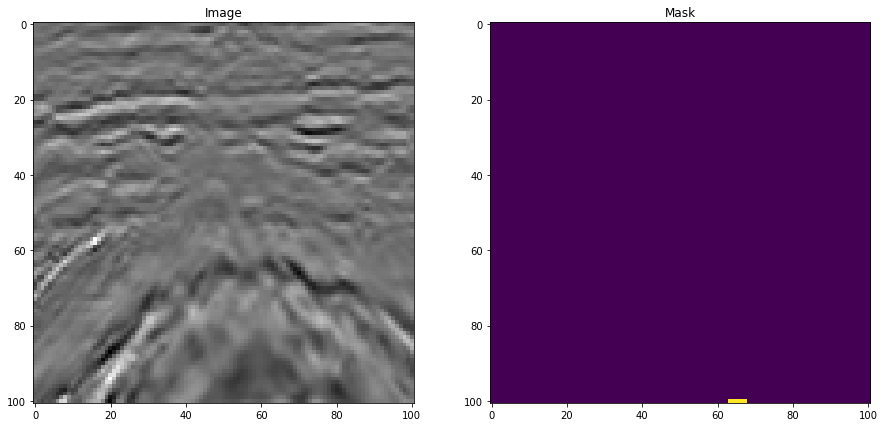

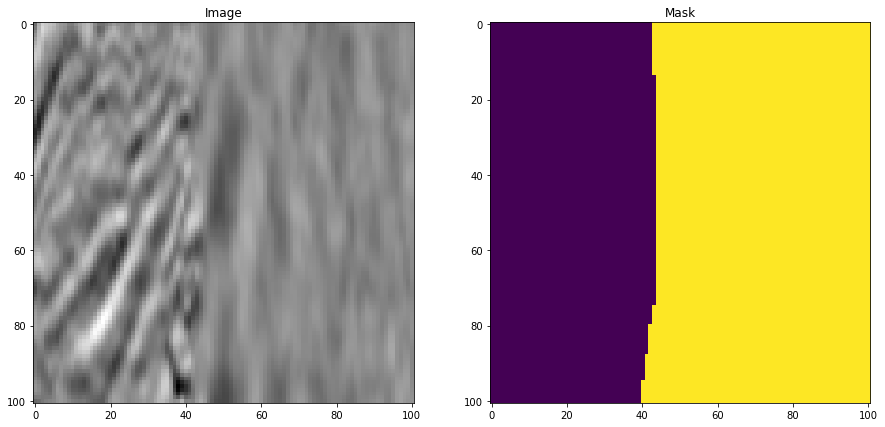

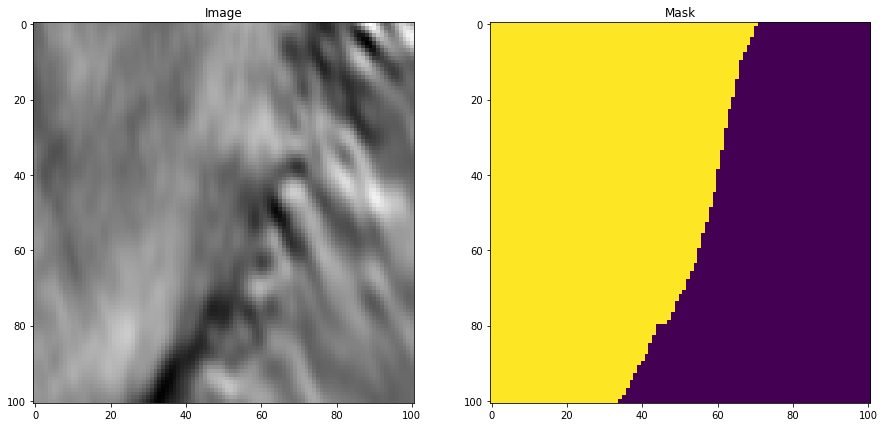

In [5]:
for i in range(5):
    random_ = np.random.randint(0, 4000)
    if type(data["rle_mask"][random_])==float:
        continue
    plt.figure(figsize=(15,10))
    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(plt.imread(data["img_path"][random_]))
    plt.subplot(1, 2, 2)
    plt.title("Mask")
    plt.imshow(plt.imread(data["mask_path"][random_]))
    plt.show()

#### Observations:
- Looking at the images and mask, it looks humanely impossible to segment these manually.
- The only defining clue that I could find was a little blurry-ness in the segmentated region of the image.
- So using "Gaussian-blur" for Image Augmentation might not be a good idea.

# EDA

<b>Type of Data provided</b>

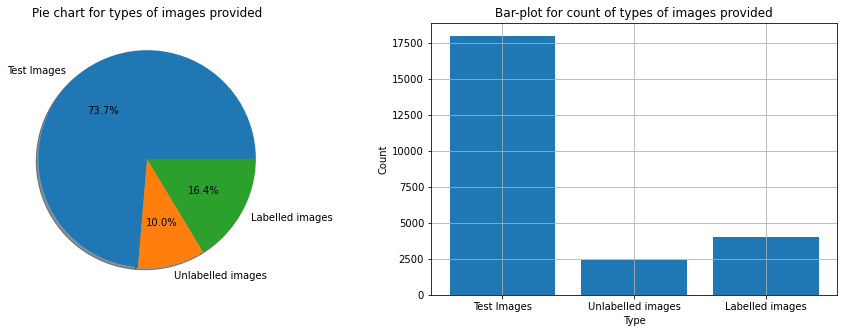

In [6]:
# Figure for proportion of data provided by type
plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
plt.pie([len(os.listdir("test/images")),len(data["rle_mask"].dropna()),data.shape[0]],\
        labels=["Test Images","Unlabelled images","Labelled images"],shadow=True,autopct='%1.1f%%')
plt.title("Pie chart for types of images provided")
plt.subplot(1,2,2)
plt.bar(["Test Images","Unlabelled images","Labelled images"],[len(os.listdir("test/images")),\
                                                               len(data["rle_mask"].dropna()),data.shape[0]])
plt.title("Bar-plot for count of types of images provided")
plt.xlabel("Type")
plt.ylabel("Count")
plt.grid()
plt.show()

#### Observations:
- The proportion of test images and unlabelled images is surprisingly high, which almost makes it look like an unsupervized learning problem

### Analysing depth

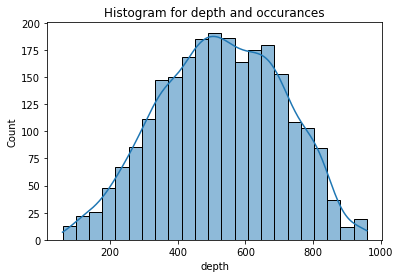

In [7]:
#removing unlabelled data points
labelled_data=data.dropna()

sns.histplot(labelled_data["depth"],kde=True)
plt.title("Histogram for depth and occurances")
plt.show()

#### Observations:
- This looks like a proper normal distribution

QQ plot

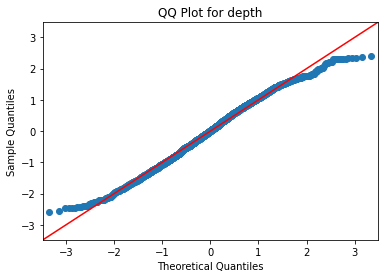

In [8]:

sm.qqplot(labelled_data["depth"],fit=True,line="45")
plt.title("QQ Plot for depth")
plt.show()

#### Observations:
- QQ-plot reiterates the same

## Is there a relationship between depth and salt content?

To find that out, one would need to find a way to quantify salt content in an image. Let's do that introducing a term called "mean_pixel_value" which is nothing but the mean of image mask. First we convert the RLE-format masks into Images in numpy array format and then store it's mean_pixel_value.


C:\Users\paras\AppData\Local\Temp\ipykernel_7292\1801342642.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labelled_data["mean_pixel_value"]=mean_pixel_value


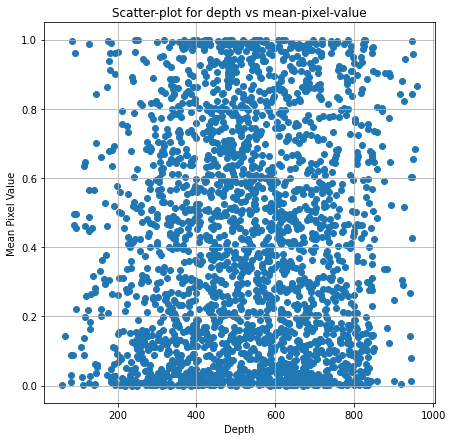

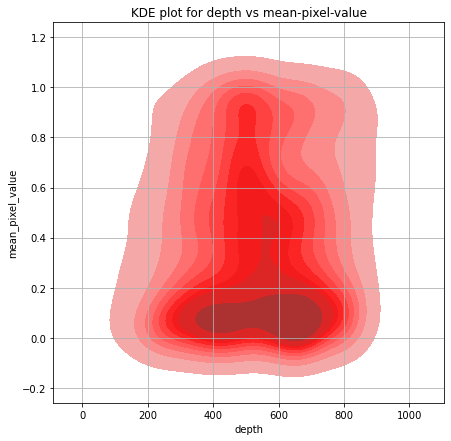

In [9]:
mean_pixel_value=[]
for j in labelled_data["rle_mask"]:
    #convert rle encoded mask to numpy array using predefined function and store it's mean pixel value
    mean_pixel_value.append(np.mean(rle_to_arr(j)))  
    
labelled_data["mean_pixel_value"]=mean_pixel_value

#scatter plot
plt.figure(figsize=(7,7))
plt.scatter(labelled_data["depth"],labelled_data["mean_pixel_value"])
plt.title("Scatter-plot for depth vs mean-pixel-value")
plt.xlabel("Depth")
plt.ylabel("Mean Pixel Value")
plt.grid()
plt.show()

#density plot
plt.figure(figsize=(7,7))
sns.kdeplot(x=labelled_data["depth"],y=labelled_data["mean_pixel_value"],color='red', fill=True)
plt.title("KDE plot for depth vs mean-pixel-value")
plt.grid()
plt.show()

#### Observations:
- Looks almost uniformly distributed

#### Checking correlation

In [10]:
labelled_data.corr()

,depth,mean_pixel_value
depth,1.000000,0.048396
mean_pixel_value,0.048396,1.000000


#### Observations:
- Correlation looks quite less, but still not worth discarding

## Mean-Pixel-Value

Mean-Pixel-Value quantifies the presence of salt deposit in each image. 

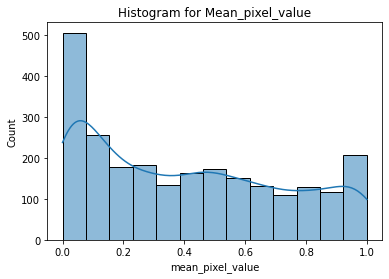

In [11]:
sns.histplot(labelled_data["mean_pixel_value"],kde=True)
plt.title("Histogram for Mean_pixel_value")
plt.show()

#### Observation:
- If not for the extreme values, mean_pixel_value looks almost uniform, which is a good thing as the number of segmentated salt deposit pixels will be almost equal to the non-salt deposit pixels.

# Conclusion:
- Only 16% of the total provided images have a label. Using only Supervised learning might not be a very good idea considering the low proportion of train data. Use <b>semi-supervized learning</b>.
- There is some correlation between Depth and Mean-Pixel-Value, so discarding it isn't worthy. <b>Use depth</b> in the segmentation model.
- Quantity of salt deposits in imaged locations is almost uniform